In [1]:
import glob
import os
import re

import matplotlib.pyplot as plt

# Text cleansing

## Search all files inside base path

In [2]:
# Path for books searching
BOOKS_BASE_PATH = '../books/'

# Keys for dictionary
MEAN_KEY = 'SentenceLengthMean'
DATASET_KEY = 'Dataset'
AUTHOR_KEY = 'Author'
BOOKS_KEY = 'Books'
DATASET_SENTENCES_MEAN = 'SentenceLengthMean'
BOOKS_PATH_KEY = 'Path'
BOOK_CONTENT_KEY = 'Content'
BOOK_SENTENCES_KEY = 'Sentences'
BOOK_SENTENCES_HIST_KEY = 'SentenceLengthHist'
BOOK_SENTENCES_MEAN = 'SentenceLengthMean'

# Regex used
# Removes chapters titles
DELETE_CHAPTER_REGEX = r'^\s*(chapter|chap|\d|[MDCLXVI]+)+'
# Remove unwanted characers
DELETE_CHARACTER_REGEX = r'[-|\_]+'
# Honorific titles regex
HONORIFIC_REGEX = r'(Mr|Mrs|Ms|Dr|Prof|Jr)\.'
# Sentence splitting
SPLIT_SENTENCE_REGEX = r'[\.|;]+'
# Splitting as words
WORDS_EXTRACTION_REGEX = r'([\W|"|\'|:|\?|!|\(|\)|\.])'
#Ignore inner content regex
IGNORE_INNER_REGEX = r'("[^"]+"|\([^\)]+\))'
# Replace valid separators(non idea separator) with this char
TEMPORAL_CHAR = '#'


#### Organizing books by author

In [3]:
datasets = []

for author in glob.glob(os.path.join(BOOKS_BASE_PATH, '*'), ):
    if os.path.isdir(author):
        datasets.append({AUTHOR_KEY: os.path.basename(author)})

print(datasets)

[{'Author': 'Oscar Wilde'}, {'Author': 'Friedrich Nietzsche'}, {'Author': 'Ernest Hemingway'}]


In [4]:
total_books = 0

for dataset in datasets:
    dataset[BOOKS_KEY] = [ {BOOKS_PATH_KEY: path} for path in glob.glob(os.path.join(BOOKS_BASE_PATH, dataset[AUTHOR_KEY], '*.txt')) ]
    total_books += len(dataset[BOOKS_KEY])

print(datasets)

[{'Author': 'Oscar Wilde', 'Books': [{'Path': '../books/Oscar Wilde/The Canterville ghost.txt'}, {'Path': '../books/Oscar Wilde/The picture of Dorian Gray.txt'}]}, {'Author': 'Friedrich Nietzsche', 'Books': [{'Path': '../books/Friedrich Nietzsche/The antichrist.txt'}, {'Path': '../books/Friedrich Nietzsche/Thus spake Zarathustra.txt'}]}, {'Author': 'Ernest Hemingway', 'Books': [{'Path': '../books/Ernest Hemingway/In our time.txt'}, {'Path': '../books/Ernest Hemingway/The old man of the sea.txt'}]}]


## Defining cleansing functions

License removal was done manually, here only clean books are considered

In [5]:
# Read file's lines 
def read_file(filename):
    content = []
    with open(filename) as f:
        for line in f:
            content.append(line.strip())

    return content

In [6]:
# Join paragraphs defined in multi-lines
def join_paragraphs(content):
    num_lines = len(content)

    paragraphs = []
    paragraph = []
    num_line = 0

    while num_line < num_lines:
        
        line = content[num_line].strip()
        
        while line:
            paragraph.append(line)
            num_line += 1

            if(num_line >= num_lines):
                break

            line = content[num_line].strip()
        
        if len(paragraph) > 0:
            paragraphs.append(' '.join(paragraph))

        num_line += 1


        paragraph.clear()

    return paragraphs

In [7]:
# delete chapters (titles)
def delete_chapters(content, regex=DELETE_CHAPTER_REGEX):
    paragraphs = []

    for paragraph in content:
        if not re.search(regex, paragraph.strip(), flags=re.IGNORECASE):
            paragraphs.append(paragraph)

    return paragraphs

In [8]:
# Remove unwanted characters
def delete_character(content, regex=DELETE_CHARACTER_REGEX):
    paragraphs = []

    for paragraph in content:
        clean_line = re.sub(regex, '', paragraph.strip(), flags=re.IGNORECASE).strip()
        if clean_line:
            paragraphs.append(clean_line)        

    return paragraphs

In [9]:
# Join previously defined functions
def process_text(filename):
    print('File: {}'.format(filename))
    text = read_file(filename)
    read_lines = len(text)
    print('Read lines: {}'.format(read_lines))
    text = join_paragraphs(text)
    num_paragraphs = len(text)
    print('Number of pargraphs: {}'.format(num_paragraphs))
    text = delete_chapters(text)
    text = delete_character(text)
    num_paragraphs_chapdel = len(text)
    print('Deleted chapters: {}'.format(num_paragraphs - num_paragraphs_chapdel))
    print('Final paragraphs: {}'.format(num_paragraphs_chapdel))
    return text

In [10]:
# Process all books
for dataset in datasets:
    for book in dataset[BOOKS_KEY]:
        print('----------------------------------------------------------')
        book[BOOK_CONTENT_KEY] = process_text(book[BOOKS_PATH_KEY])
    

----------------------------------------------------------
File: ../books/Oscar Wilde/The Canterville ghost.txt
Read lines: 1089
Number of pargraphs: 108
Deleted chapters: 14
Final paragraphs: 94
----------------------------------------------------------
File: ../books/Oscar Wilde/The picture of Dorian Gray.txt
Read lines: 8358
Number of pargraphs: 1509
Deleted chapters: 140
Final paragraphs: 1369
----------------------------------------------------------
File: ../books/Friedrich Nietzsche/The antichrist.txt
Read lines: 2729
Number of pargraphs: 194
Deleted chapters: 81
Final paragraphs: 113
----------------------------------------------------------
File: ../books/Friedrich Nietzsche/Thus spake Zarathustra.txt
Read lines: 13151
Number of pargraphs: 3694
Deleted chapters: 729
Final paragraphs: 2965
----------------------------------------------------------
File: ../books/Ernest Hemingway/In our time.txt
Read lines: 446
Number of pargraphs: 65
Deleted chapters: 26
Final paragraphs: 39
--

# Sentences split

In [11]:

def split_sentences(text, 
    honorific_regex=HONORIFIC_REGEX,
    ignore_inner_regex=IGNORE_INNER_REGEX,
    split_regex=SPLIT_SENTENCE_REGEX, 
    words_extraction_regex=WORDS_EXTRACTION_REGEX, 
    temp_char=TEMPORAL_CHAR
    ):

    honorific_temp_str = ''.join([temp_char * 5])
    inner_temp_str = ''.join([temp_char * 10])
    
    # Removes honorific and inner ignore
    result_honorific_remove_group = re.findall(honorific_regex, text)
    result_honorific_remove = re.sub(honorific_regex, honorific_temp_str, text)
    result_inner_ignore_group = re.findall(ignore_inner_regex, result_honorific_remove, flags=re.IGNORECASE)
    result_inner_ingore = re.sub(ignore_inner_regex, inner_temp_str, result_honorific_remove, flags=re.IGNORECASE)
    
    honorific_group = 0
    inner_group = 0
    
    sentences_words = []  
    
    # Split sentences
    sentences = re.split(split_regex, result_inner_ingore)

    for sentence in sentences:
        # Restore inner and honorific
        while re.search(inner_temp_str, sentence):
            sentence = sentence.replace(inner_temp_str, result_inner_ignore_group[inner_group])
            inner_group += 1

        while re.search(honorific_temp_str, sentence):
            sentence = sentence.replace(honorific_temp_str, result_honorific_remove_group[honorific_group])
            honorific_group += 1

        # Split in words
        splitted_sentence = re.split(words_extraction_regex, sentence)
        splitted_sentence = [sp for sp in splitted_sentence if sp.strip() ]
        if len(splitted_sentence) > 0:
            sentences_words.append(splitted_sentence)
    
    return sentences_words


In [12]:

data = {}

datasets_mean = 0
datasets_total = 0

for dataset in datasets:

    books_mean = 0
    books_total = 0

    for book in dataset[BOOKS_KEY]:

        sentences_length_histogram = {}

        book[BOOK_SENTENCES_KEY] = []
        for paragraph in book[BOOK_CONTENT_KEY]:
            splitted_sentences = split_sentences(paragraph)
            book[BOOK_SENTENCES_KEY].extend(splitted_sentences)
            for sentence in splitted_sentences:
                if len(sentence) in sentences_length_histogram:
                    sentences_length_histogram[len(sentence)] += 1
                else:
                    sentences_length_histogram[len(sentence)] = 1

        book[BOOK_SENTENCES_HIST_KEY] = sentences_length_histogram
        
        mean = 0
        total = 0

        for key in book[BOOK_SENTENCES_HIST_KEY]:
            mean += (key * book[BOOK_SENTENCES_HIST_KEY][key])
            total += book[BOOK_SENTENCES_HIST_KEY][key]

        book[BOOK_SENTENCES_MEAN] = mean / total

        books_mean += mean
        books_total += total

        print('----------------------------------------------------------')
        print('Book: {}'.format(book[BOOKS_PATH_KEY]))
        print('Paragraphs: {}'.format(len(book[BOOK_CONTENT_KEY])))
        print('Sentences: {}'.format(len(book[BOOK_SENTENCES_KEY])))
        print('Sentences domain length: {}'.format(len(book[BOOK_SENTENCES_HIST_KEY])))
        print('Book mean length: {}'.format(book[BOOK_SENTENCES_MEAN]))

    
    datasets_mean += books_mean
    datasets_total += books_total
    
    dataset[DATASET_SENTENCES_MEAN] = books_mean / books_total

    print('==========================================================')
    print('Dataset mean length: {}'.format(dataset[DATASET_SENTENCES_MEAN]))


data[MEAN_KEY] = datasets_mean / datasets_total
print('**********************************************************')
print('Total mean length: {}'.format(data[MEAN_KEY]))


data[DATASET_KEY] = datasets


----------------------------------------------------------
Book: ../books/Oscar Wilde/The Canterville ghost.txt
Paragraphs: 94
Sentences: 350
Sentences domain length: 80
Book mean length: 31.405714285714286
----------------------------------------------------------
Book: ../books/Oscar Wilde/The picture of Dorian Gray.txt
Paragraphs: 1369
Sentences: 3073
Sentences domain length: 164
Book mean length: 25.370647575658964
Dataset mean length: 25.987730061349694
----------------------------------------------------------
Book: ../books/Friedrich Nietzsche/The antichrist.txt
Paragraphs: 113
Sentences: 886
Sentences domain length: 97
Book mean length: 27.548532731376977
----------------------------------------------------------
Book: ../books/Friedrich Nietzsche/Thus spake Zarathustra.txt
Paragraphs: 2965
Sentences: 4529
Sentences domain length: 82
Book mean length: 19.562155001103996
Dataset mean length: 20.868882733148663
----------------------------------------------------------
Book: ../b

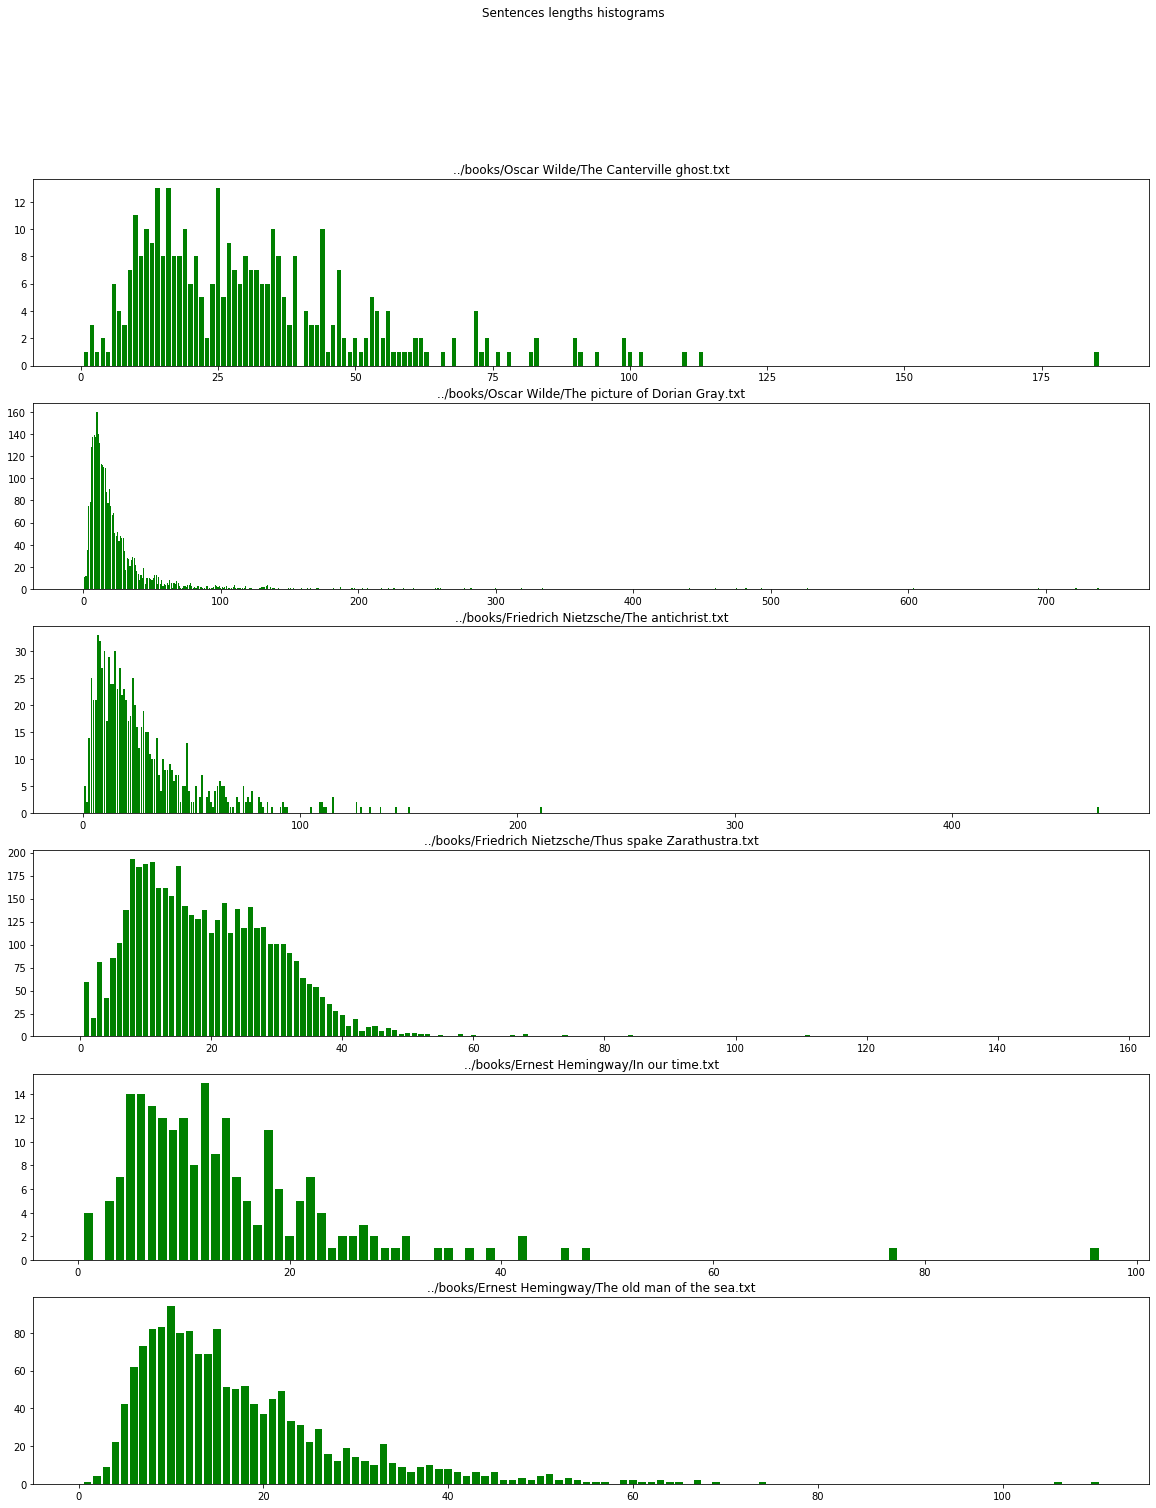

In [13]:
fig, axs = plt.subplots(total_books, figsize=(20, 4 * total_books))
fig.suptitle('Sentences lengths histograms')

current_book = 0

for dataset in datasets:
    for book in dataset[BOOKS_KEY]:
        axs[current_book].set_title(book[BOOKS_PATH_KEY])
        axs[current_book].bar(book[BOOK_SENTENCES_HIST_KEY].keys(), book[BOOK_SENTENCES_HIST_KEY].values(), color='g')
        current_book += 1